In [1]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from matplotlib.image import imread
import matplotlib.pyplot as plt
import random
from PIL import Image

IMG_SIZE = 224
batch_size = 1
NUM_CLASSES = 3

from official.vision.image_classification.efficientnet import efficientnet_model

In [3]:
from IPython.display import clear_output


def load_lightfield_data(lf_directory):
    """
    Loads the center image (003) from each light field.
    
    :param lf_directory: Path to directory
    :return: features: (#LF, resX, resY, RGB)
             labels: (#LF)
    """
    good = 0
    scratch = 0
    dent = 0
    error = 0
    image_dirs = []
    for path, subdirs, files in os.walk(lf_directory):
        for name in files:
            if '0001_Set0_Cam_003_img.png' in name:
                image_dirs.append(os.path.join(path, name))
    random.seed(1)
    random.shuffle(image_dirs)
    print(len(image_dirs))
    features = np.zeros((len(image_dirs), IMG_SIZE, IMG_SIZE, 3), np.float32)
    labels = np.zeros((len(image_dirs)), np.int64)
    for i, lf in enumerate(image_dirs):
        clear_output()
        print(lf, flush=True)
        with Image.open(lf) as im:
            im_resize = np.array(im.resize((IMG_SIZE, IMG_SIZE))).astype('float32')
        
        features[i, :, :, :] = im_resize[:, :, :3]  # center image ,[:,:,3] is alpha channel
        # 0: no defect, 1: scratch, 2: dent
        if 'good' in lf:
            gt = 0
            good += 1
        elif 'scratch' in lf:
            gt = 1
            scratch += 1
        elif 'dent' in lf:
            gt = 2
            dent += 1
        labels[i] = gt
        
    print(f"Good: {good} : {good/(good+scratch+dent+error)}")
    print(f"Scratch: {scratch} : {scratch / (good + scratch + dent + error)}")
    print(f"Dent: {dent} : {dent / (good + scratch + dent + error)}")
    print(f"Error: {error} : {error / (good + scratch + dent + error)}")
    grey = 0.299*features[:,:,:,0] + 0.587*features[:,:,:,1] + 0.114*features[:,:,:,2]
    features[:,:,:,0] = grey
    features[:,:,:,1] = grey
    features[:,:,:,2] = grey
    
    return features/255, labels  # Data does not need to be normalized, it's part of the model

In [4]:
# (x_all, y_all) = load_lightfield_data("C:\\Users\\rmueller\\Google Drive\\University\\Master_Project\\data_storage\\lightfields_nohdr")
# (x_all, y_all) = load_lightfield_data("C:\\Users\\muell\\Google Drive\\University\\Master_Project\\data_storage\\lightfields")
(x_all, y_all) = load_lightfield_data("C:\\Users\\muell\\desktop\\1part_1background")


C:\Users\muell\desktop\1part_1background\dent\1266_m0_sc14.93_s0.98_r0.64_m1.0_r1.11_t1.65_p1.46\0001_Set0_Cam_003_img.png
Good: 1114 : 0.5649087221095335
Scratch: 420 : 0.2129817444219067
Dent: 438 : 0.22210953346855983
Error: 0 : 0.0


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3, random_state=1)
x_train.shape

(1380, 224, 224, 3)

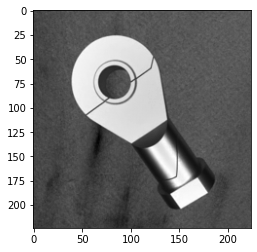

In [6]:
plt.imshow((((0.3*x_all[4,:,:,0]+0.58*x_all[4,:,:,1]+0.11*x_all[4,:,:,2])*255).astype(np.uint8)).astype("uint8"),
          cmap='gray')

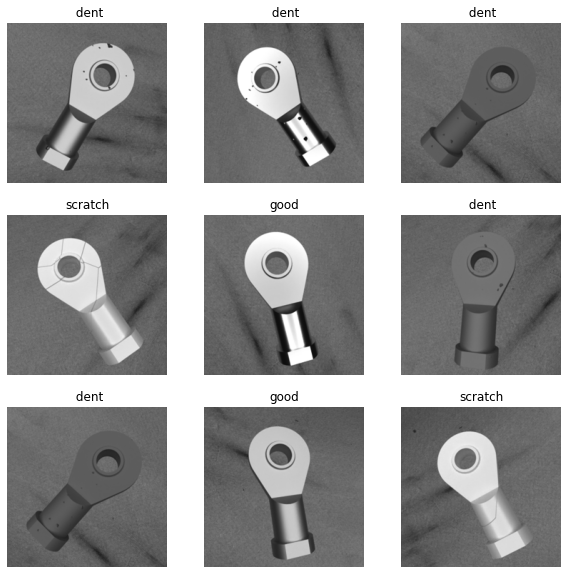

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
    k = np.random.randint(0,100)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((x_all[k]*255).astype("uint8"))
    plt.title({0:'good', 1:'scratch', 2:' dent'}[y_all[k]])
    plt.axis("off")

In [15]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.12),
        preprocessing.RandomTranslation(height_factor=0.03, width_factor=0.03),
        preprocessing.RandomFlip(),
#         preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

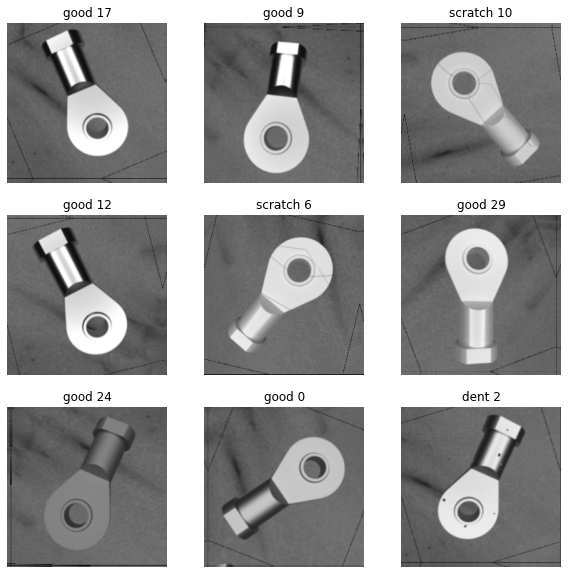

In [16]:
plt.figure(figsize=(10,10))
for i in range(9):
    j = np.random.randint(0,30)
    ax = plt.subplot(3, 3, i + 1)
    aug_img = img_augmentation(tf.expand_dims(x_test[j], axis=0))
    plt.imshow((aug_img[0].numpy()*255).astype("uint8"))
    plt.title({0:f'good {j}', 1:f'scratch {j}', 2:f'dent {j}'}[y_test[j]])
    plt.axis("off")

In [17]:
y_train_cat = tf.one_hot(y_train, NUM_CLASSES)
y_test_cat = tf.one_hot(y_test, NUM_CLASSES)
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)

In [18]:
from tensorflow.keras import Model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
EN = efficientnet_model.EfficientNet(overrides={'input_channels':3,'rescale_input':False, 'num_classes':3})

outputs = EN(x)

model = Model(inputs, outputs)

metrics = ['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=metrics)
model.summary()
model.fit(x=x_train, y=y_train_cat, epochs=100, batch_size=16,
                 validation_data=(x_test, y_test_cat), verbose=2)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnet (EfficientNet)  (None, 3)                 4053407   
Total params: 4,053,407
Trainable params: 4,011,391
Non-trainable params: 42,016
_________________________________________________________________
Epoch 1/100


87/87 - 15s - loss: 3.2845 - accuracy: 0.4246 - precision: 0.4271 - recall: 0.4014 - val_loss: 1.8866 - val_accuracy: 0.2027 - val_precision: 0.2027 - val_recall: 0.2027
Epoch 2/100
87/87 - 13s - loss: 2.0349 - accuracy: 0.4529 - precision: 0.4709 - recall: 0.3754 - val_loss: 1.4504 - val_accuracy: 0.5878 - val_precision: 0.5878 - val_recall: 0.5878
Epoch 3/100
87/87 - 13s - loss: 1.6772 - accuracy: 0.4688 - precision: 0.5037 - recall: 0.3442 - val_loss: 1.1864 - val_accuracy: 0.5878 - val_precision: 0.5878 - val_recall: 0.5878
Epoch 4/100
87/87 - 13s - loss: 1.4827 - accuracy: 0.5145 - precision: 0.5448 - recall: 0.3746 - val_loss: 1.1890 - val_accuracy: 0.5878 - val_precision: 0.5878 - val_recall: 0.5878
Epoch 5/100
87/87 - 13s - loss: 1.4577 - accuracy: 0.5326 - precision: 0.5358 - recall: 0.3797 - val_loss: 1.1710 - val_accuracy: 0.5878 - val_precision: 0.5878 - val_recall: 0.5878
Epoch 6/100
87/87 - 13s - loss: 1.3923 - accuracy: 0.5152 - precision: 0.5157 - recall: 0.3442 - val_l

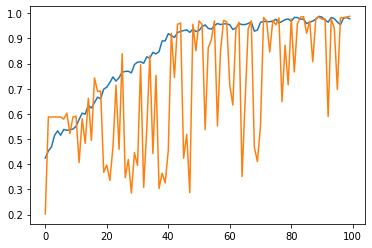

In [24]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])

In [26]:
model.evaluate(x=x_train, y=y_train_cat)

44/44 [==============================] - 2s 50ms/step - loss: 0.1333 - accuracy: 0.9913 - precision: 0.9913 - recall: 0.9913: 1s - loss: 0.1283 - accuracy: 0.9915 - pre


[0.13325385749340057, 0.991304337978363, 0.991304337978363, 0.991304337978363]